# Gene perturbation general pipeline, identification of cell types most affected by treatment

## Description

This notebook covers  functions to analyze data from single cell gene perturbation experiments (e.g. CRISPR-Cas9) to find cell types affected by perturbations using [Augur](https://github.com/neurorestore/Augur) applied to [Kang et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29227470/), which is a 10x scRNA-seq PBMC dataset from Lupus patients before and after 6h-treatment with INF-beta (8 patients, 16 samples, 8 cell types).         

Notes:   Augur has the following limitations: a) might not allow for fine-grained enough rankings, b) it discards cell type relative abundances, c) does not decipher individual cells perturbation responses--although this applied to all cell type based methods, d) here we use Augur's re-implementation from [scverse/pertpy](https://github.com/scverse/pertpy).



In [1]:
import warnings
import os
import pertpy as pt ## Tested v1.0.0
import scanpy as sc
import pandas as pd
from matplotlib import rcParams
import gseapy
import numpy as np

### Note: using numpy<2.0 to avoid version issues

warnings.filterwarnings("ignore")

/Users/jdime/venv_bioinfo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Find cell types affected by perturbations in a control vs. IFN-beta experiment

#### Load and massage Kang AnnData

In [2]:
adata = pt.dt.kang_2018()

### Rename conditions to compare
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

### Reformat metadata provided by Heumos et al
adata.obs['cluster'] = "c_" + adata.obs['cluster'].astype('str')
adata.obs['seurat_clusters'] = "c_" + adata.obs['seurat_clusters'].astype('str')
cluster_v_celltype  = pd.crosstab(adata.obs['cluster'], adata.obs['cell_type'])
seurat_v_celltype   = pd.crosstab(adata.obs['seurat_clusters'], adata.obs['cell_type'])

print(adata, adata.obs.cell_type.value_counts(), adata.obs.condition.value_counts(), sep = '\n\n')

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

cell_type
CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: count, dtype: int64

condition
stimulated    12358
control       12315
Name: count, dtype: int64


#### Create Augur object

In [3]:
adata_backup = adata.copy()
ag_rfc = pt.tl.Augur("random_forest_classifier")
loaded_data = ag_rfc.load(adata, label_col="condition", cell_type_col="cell_type")
loaded_data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'y_'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

#### Run Augur
Note: there are two modes to select features:     
1) `select_variance_feature=True` removes features with little cell-to-cell variation within that cell type and results are similar to the original Augur author's R implementation
2) `scanpy.pp.highly_variable_genes` faster, and useful for large datasets.
3) In this example, since we do not expect INF-beta to have a marked effect on specific cell types, to increase the resolution, we set the `subsample_size` to 20 (default: 50).

In [4]:
v_adata, v_results = ag_rfc.predict(loaded_data, subsample_size=20, n_threads=4, select_variance_features=True, span=1)
adata.obs = adata.obs.merge(v_adata.obs['augur_score'], left_index=True, right_index=True, how='left')
v_results["summary_metrics"]

! Set smaller span value in the case of a `segmentation fault` error.
! Set larger span in case of svddc or other near singularities error.


,CD14+ Monocytes,CD4 T cells,Dendritic cells,NK cells,CD8 T cells,B cells,FCGR3A+ Monocytes,Megakaryocytes
mean_augur_score,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_auc,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_accuracy,0.817033,0.601172,0.744249,0.610330,0.575714,0.674505,0.780330,0.510513
mean_precision,0.835072,0.630593,0.779699,0.642700,0.587059,0.742801,0.792996,0.526175
mean_f1,0.806636,0.564695,0.735157,0.591230,0.552114,0.633906,0.780933,0.406510
mean_recall,0.826349,0.575714,0.756032,0.616984,0.580000,0.622540,0.816508,0.388413


From the table above, `mean_augur_score` (mean Augur Area Under the Curve) indicates the ability of the method to discern between control and perturbed cell states (stimulated vs. non-stimulated) for each cell type.

#### Visualization of results

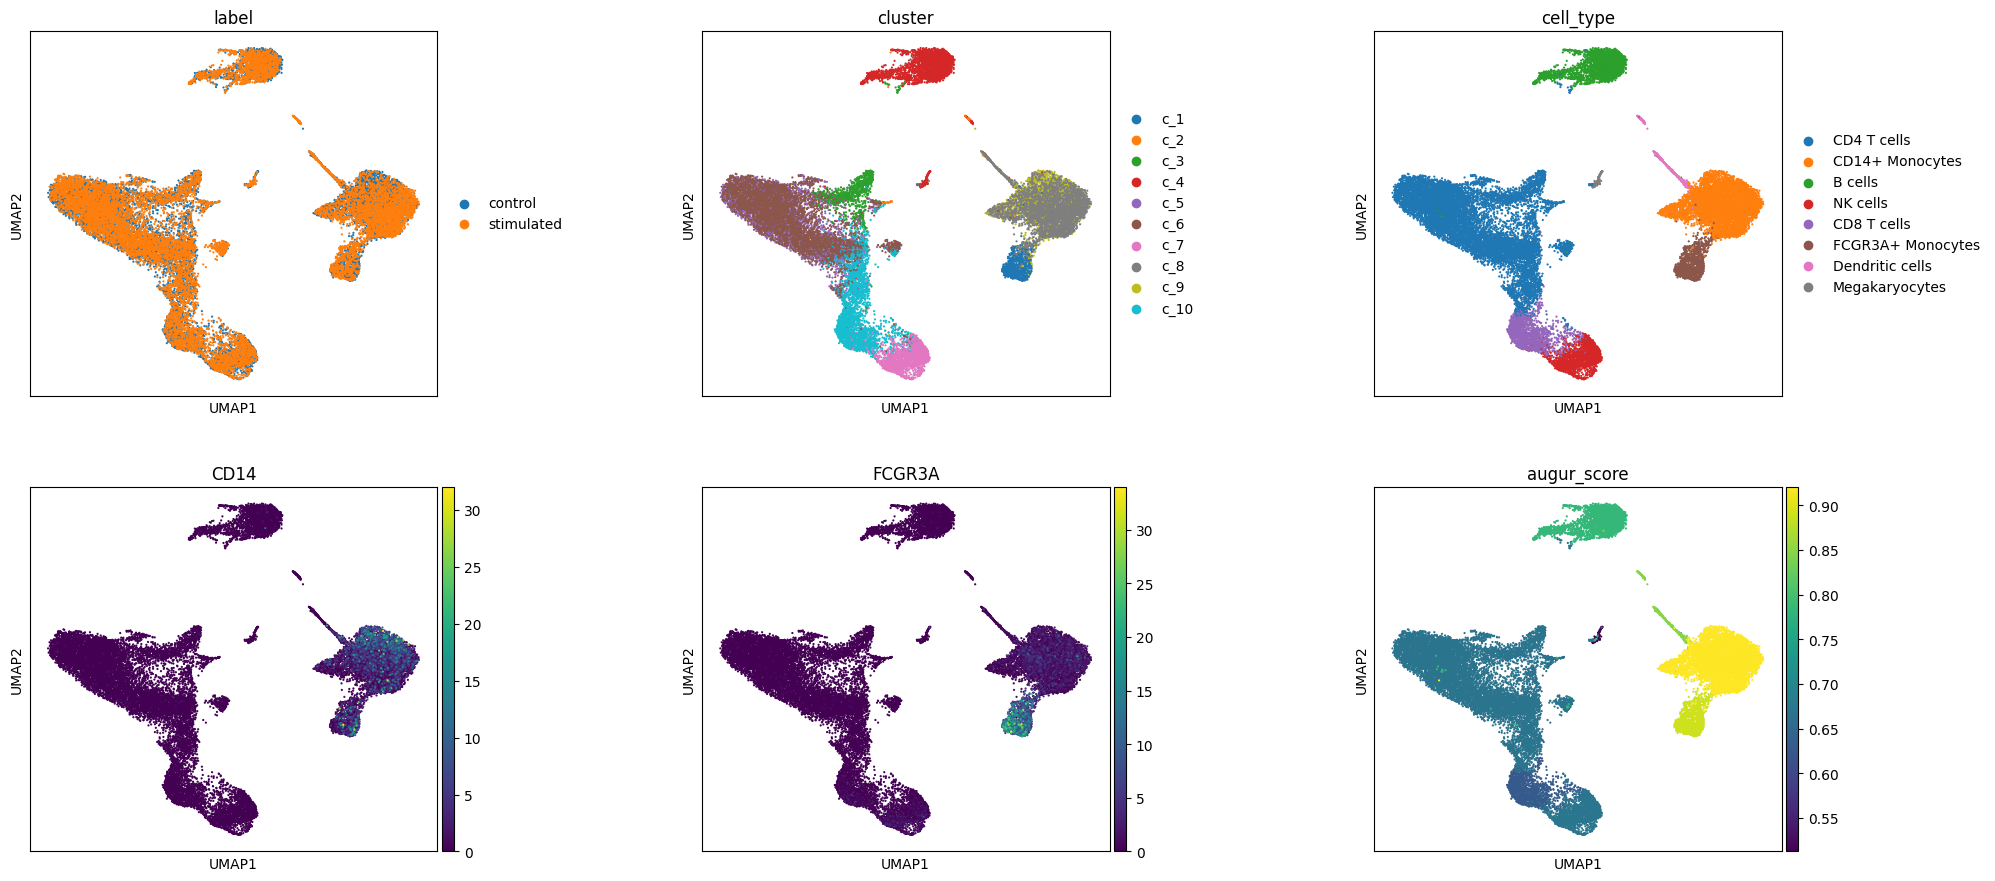

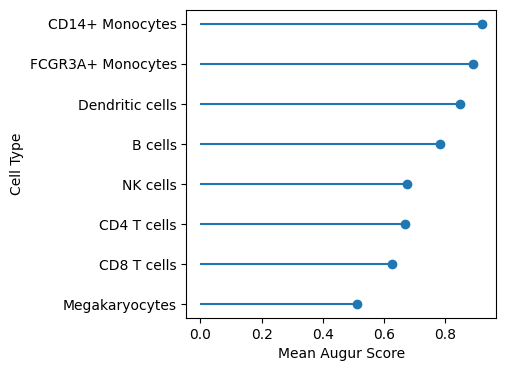

In [5]:
marker_genes = ['CD14','FCGR3A']
categories_umap = ['label', 'cluster', 'cell_type']

FIGSIZE = (5, 5)
rcParams["figure.figsize"] = FIGSIZE
sc.pl.umap(adata, color=categories_umap +  marker_genes + ['augur_score'],
           wspace=0.5, s=10, ncols=3)

FIGSIZE = (4, 4)
rcParams["figure.figsize"] = FIGSIZE
lollipop = ag_rfc.plot_lollipop(v_results)

#### Summary

CD14+ Monocytes (mainly represented in clusters c_8 and c_9) and FCGR3A+ Monocytes (mainly c_1) were the most affected by IFN-beta, whereas Megakaryocytes were the least affected. This corresponds roughly to the number of differentially expressed genes in the original [Kang et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29227470/) publication for the respective cell types.

## Find genes and pathways affected by perturbations in a control vs. IFN-beta experiment

#### Plotting the most important genes for prioritization



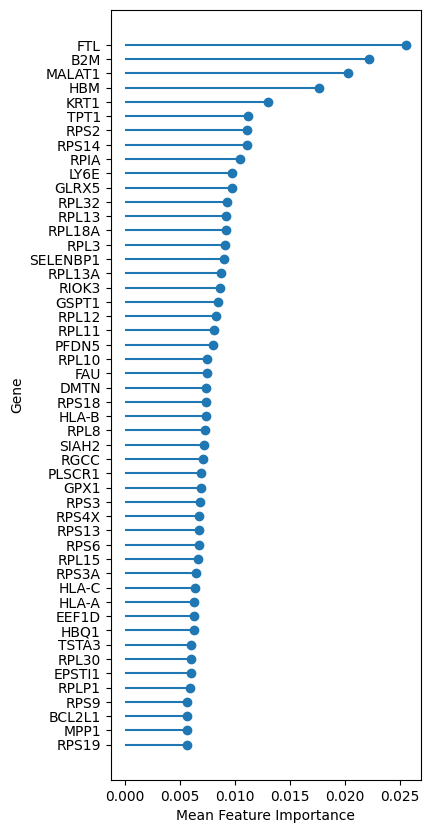

In [24]:
FIGSIZE = (4, 10)
rcParams["figure.figsize"] = FIGSIZE
important_features = ag_rfc.plot_important_features(v_results, top_n = 50, return_fig=True)

#### Gene set enrichment (Enrichr)

In [35]:
gene_importance_df = v_results['feature_importances'].groupby(['genes'])['feature_importances'].mean().sort_values(ascending=False).to_frame()
top50 = list(gene_importance_df.iloc[:50].index)
outdir = os.path.expanduser("~/temp")
gseapy.enrichr(gene_list=top50, gene_sets='KEGG_2016', outdir=outdir)
enrichr_res = pd.read_csv(os.path.join(outdir, "KEGG_2016.human.enrichr.reports.txt"), sep='\t')
enrichr_res['-log10 P-value'] = -np.log10(enrichr_res['P-value'])

<Axes: ylabel='Term'>

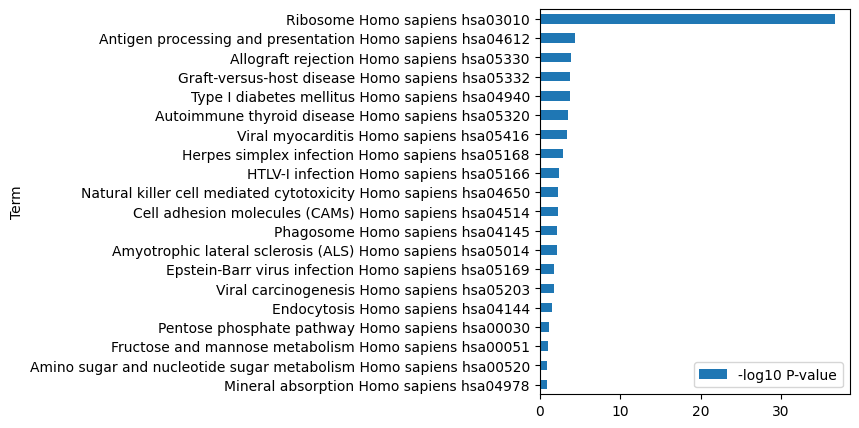

In [96]:
FIGSIZE = (4, 5)
rcParams["figure.figsize"] = FIGSIZE
enrichr_res.head(20).iloc[::-1].plot(x='Term', y='-log10 P-value', kind='barh')

#### Summary

In this a control vs. IFN-beta experiment, a number of ribosomal protein genes (whose names start with RP*), this observation was confirmed using a gene set enrichment analysis with Enrichr's implementation in GSEAPY, where the top category was the "Ribosome [hsa03010]" , followed by "Antigen processing and presentation [hsa04612].

## Sources

1) "Best practices for single-cell analysis across modalities" by [Heumos et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37002403/)
2) [GSEAPY: Gene Set Enrichment Analysis in Python](https://gseapy.readthedocs.io/en/latest/gseapy_tutorial.html)